# Section: Visualisation of Data, Clustering and Network Graphs

## This section provides a short explanation the code, what the data represents and why

In [1]:
import sklearn as skl
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import math
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import janitor
import random
import re
import collections
import networkx as nx
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from collections import namedtuple
from random import randint

The following statements regard the output display in Jupyter and custom named Tuples.
The tuples are named "Point" to represent each co-ordinate on the canvas.

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
Point = collections.namedtuple('Point', 'x y')

It is very important that any new insturment added is included in each sheet found in the excel file.
The format should be as the provided insturments.

In [4]:
df = pd.read_excel('DataFile.xlsx', sheet_name='QualitySheet')
pf = pd.read_excel('DataFile.xlsx', sheet_name='PhaseSheet')
ds = pd.read_excel('DataFile.xlsx', sheet_name='SequenceSheet')
ess = pd.read_excel('DataFile.xlsx', sheet_name='EntireSequenceSheet')

Adding jittering to data for easier representation as values are natural numbers.
This would also make it valuable for clustering as it cannot be done adequately on natural numbers.

In [5]:
jitteredDf = df.copy()
sample = df.copy()
sample = sample.drop(columns=['Quality'])
sample = sample.columns.values.tolist()

In [6]:
for f in sample:
    jitteredDf.jitter(
        column_name=f,
        dest_column_name=f,
        scale=0.5,
        clip=None,
        random_state=1565 ## Seed was added for consistent results
    )

### Data Visualisation

The purpose of this graphic is to quickly indicate which insturment are used in a procedure.

In [7]:
meltedPhases = pf.melt('Procedures', var_name='Instruments')

In [8]:
def radarPlotSize(dataFrame):
    val = round(len(dataFrame.index)/10)
    if(val <= 1):
        val += 1
    return val

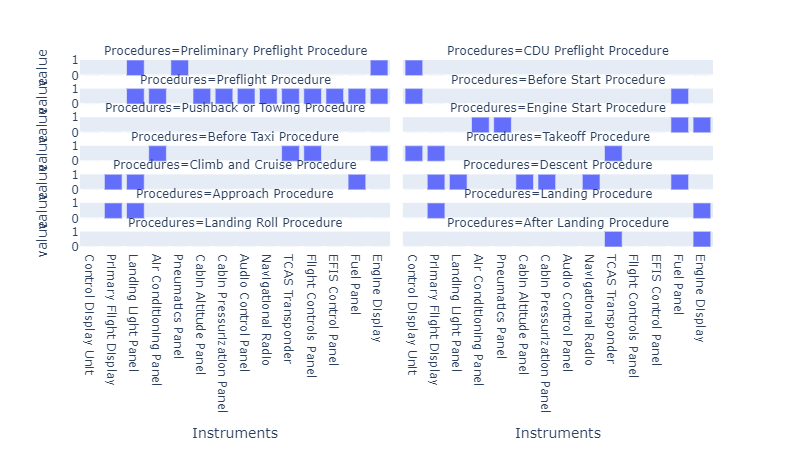

In [9]:
fig = px.bar(meltedPhases, x="Instruments", y="value",
             facet_col="Procedures",
            facet_col_wrap=radarPlotSize(pf))
fig.update_yaxes(range=[0,1])
fig.update_yaxes(nticks=2)
fig.show()

The following graphic was used before jittering was introduced. As can be seen, the data cannot be represented well as the points would overlap.
The solution to this was to use a swarmplot which plots the data in a swarm like fashion. Unfortunatly, due to the size of the graph and the values all being whole numbers, it is not usable.
Clustering cannot be done on such a graph and so jittering has to be introduced.

In [10]:
meltedDf = df.melt('Quality', var_name='Instruments')

In [11]:
jitteredMelt = jitteredDf.melt('Quality', var_name='Instruments')

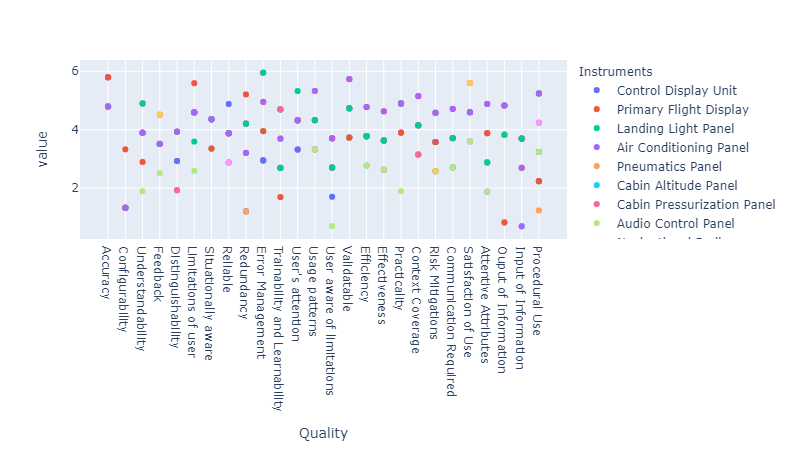

In [12]:
fig = px.scatter(jitteredMelt, x="Quality", y="value", color="Instruments")
fig.show()

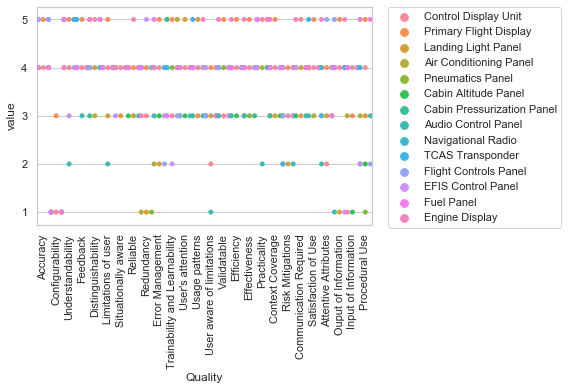

In [13]:
y = [1, 2, 3, 4, 5]
yint = range(min(y), math.ceil(max(y))+1)
sns.set(style="whitegrid", color_codes=True)
g = sns.swarmplot(x="Quality", y="value", hue='Instruments', data=meltedDf)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.rcParams['figure.figsize'] = [25, 25]
plt.yticks(yint)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The following diagram is the same plot as above, but the data is jittered.
This is more suitable for clustering.

### Radar Graphs

Functions getColPalette and printRadarPlots are used to produce a radar-plot/radar-chart.
The plots had to be displayed in a loop in-order to get around outputting of graphs in Jupyter Lab.
getColPalette is a quick implementation of generating and assigning colours to each plot.

In [14]:
def getColPalette():
    hex_colors_dic = {}
    rgb_colors_dic = {}
    hex_colors_only = []
    for name, hex in mpl.colors.cnames.items():
        hex_colors_only.append(hex)
        hex_colors_dic[name] = hex
        rgb_colors_dic[name] = mpl.colors.to_rgb(hex)
    return random.choice(hex_colors_only)

In [15]:
def printRadarPlots(dataDF, colName):
    ## Since we are using DF which is un-edited at this point in the program, I am going to assume that the Quality column is in the dataFrame
    fig = make_subplots(rows=1, cols=1, specs=[[{"type": "polar"}]])
    fig.add_trace(go.Scatterpolar(
        name=colName,
        r=dataDF[colName],
        theta=dataDF['Quality'],
        marker_color = getColPalette(),
        fill='toself'
        ), 1, 1)
    fig.update_layout(height=500, width=500, title_text=colName)
    fig.show()

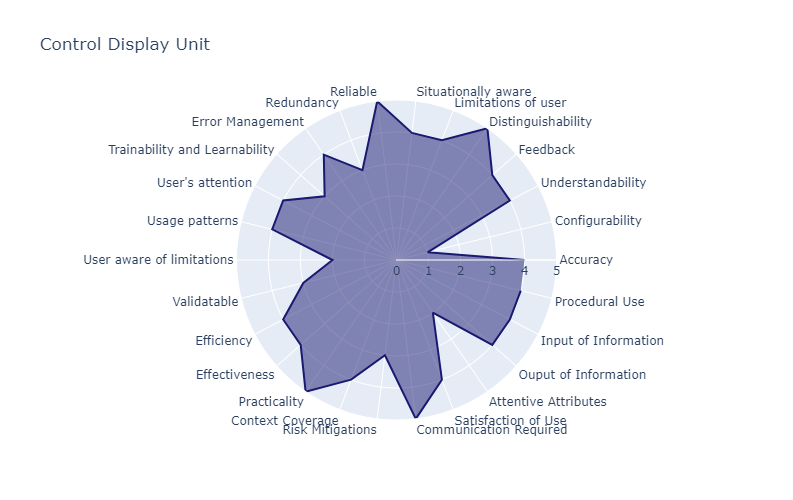

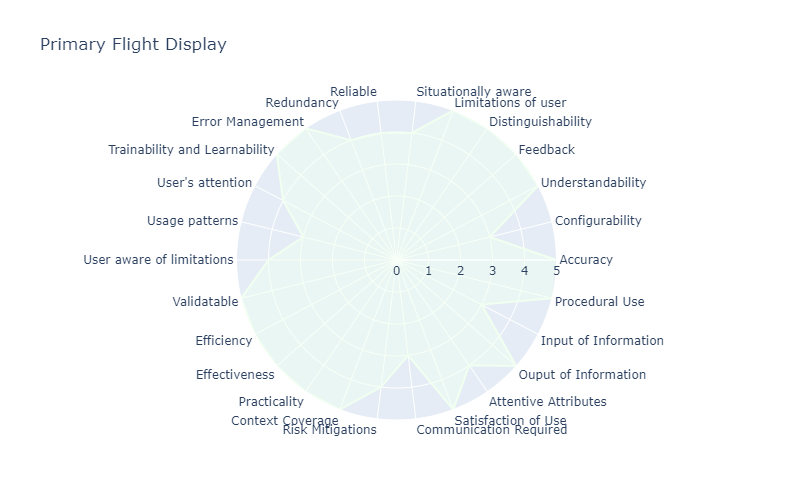

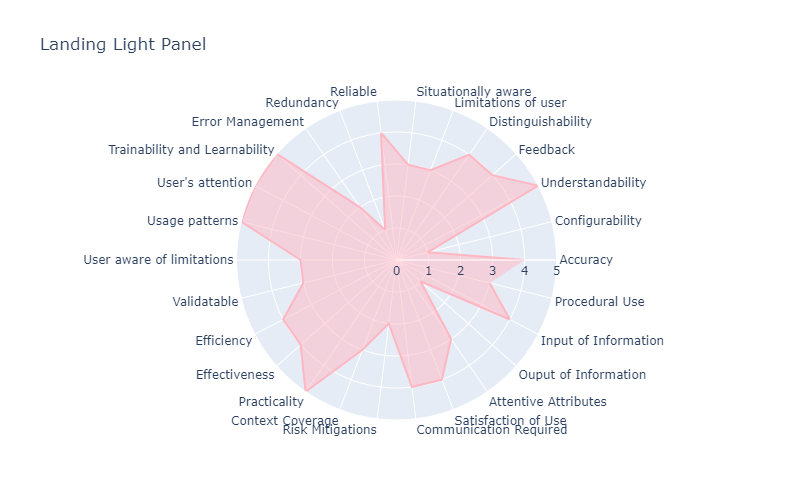

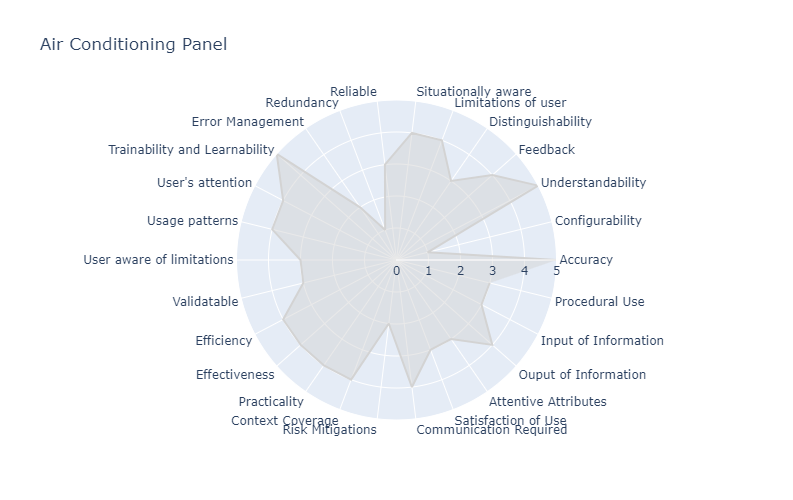

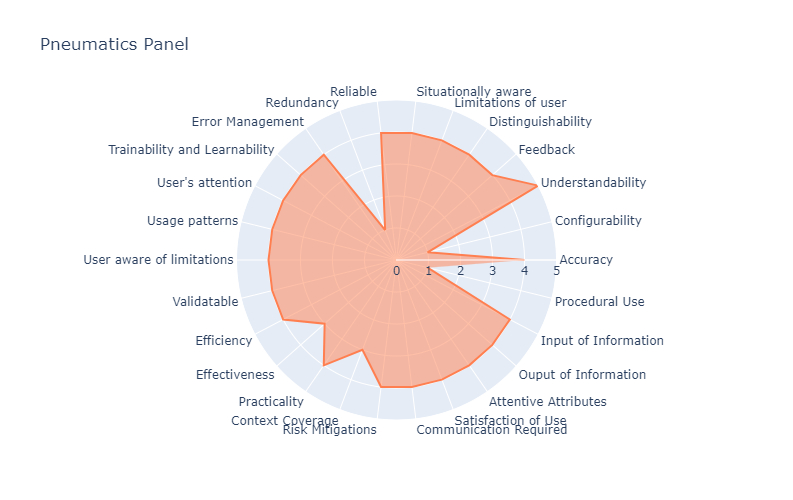

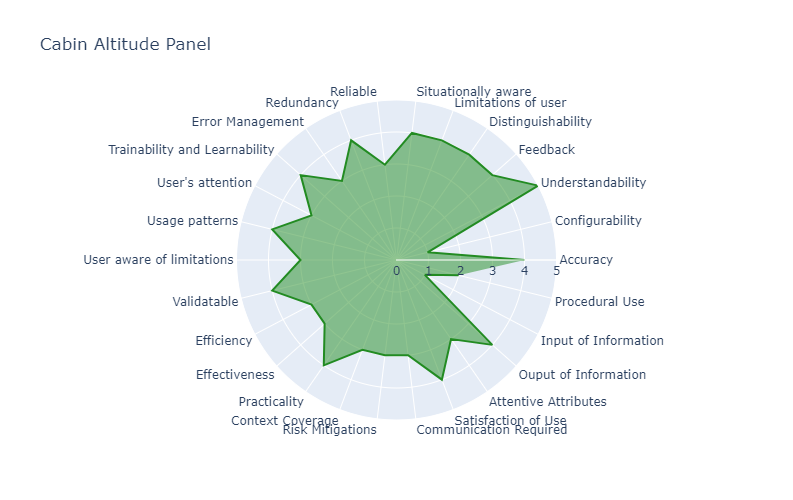

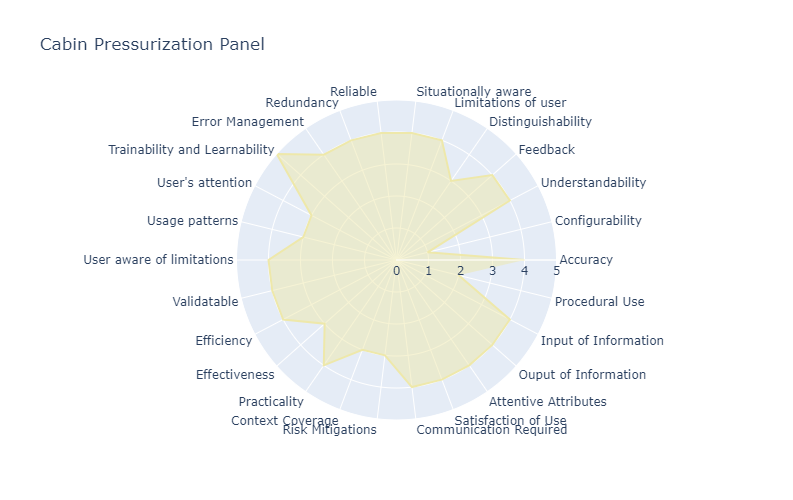

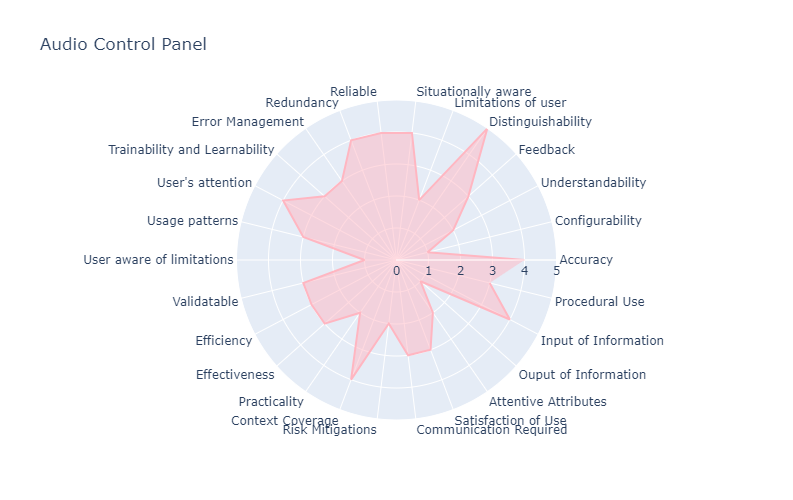

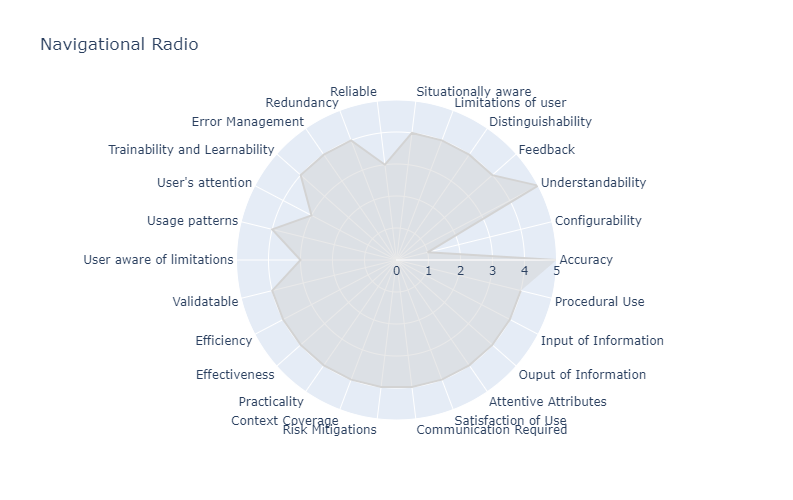

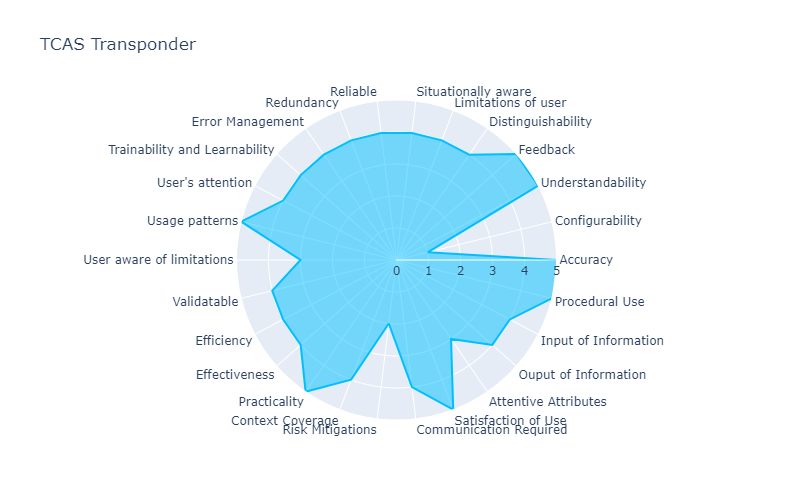

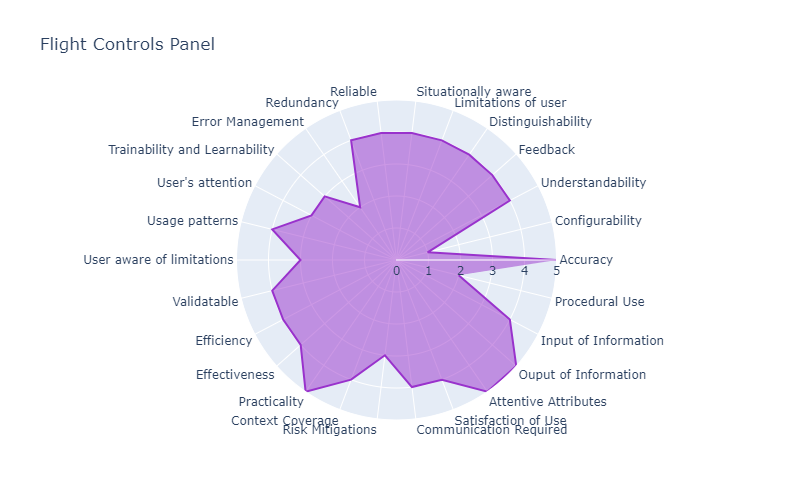

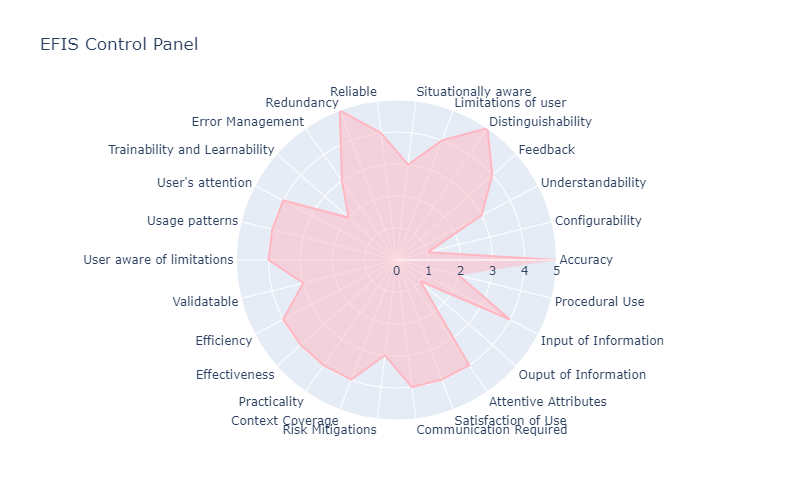

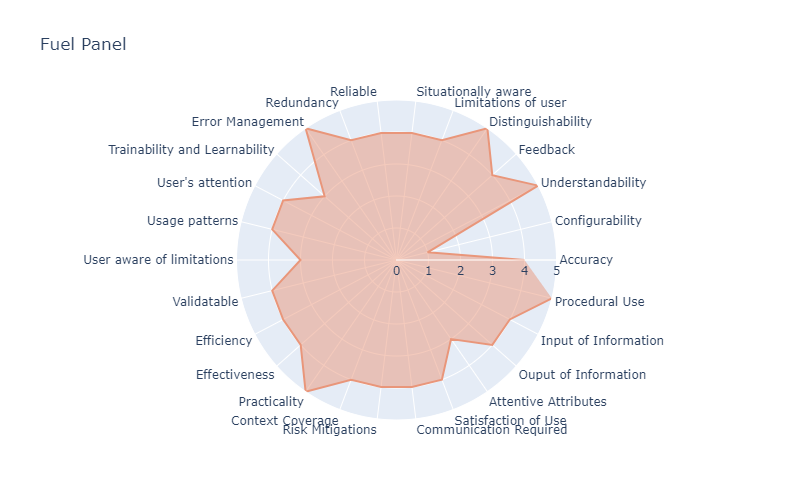

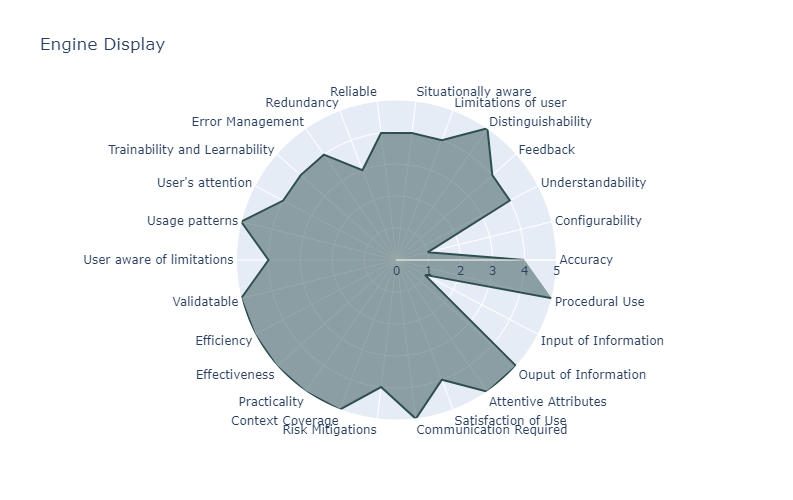

In [16]:
for col in df.columns:
    if col != 'Quality':
        printRadarPlots(df, col)

### Clustering

In [17]:
X = jitteredDf.iloc[:,1:].values

The elbow method is to help data scientists select the optimal number of clusters by fitting the model with a range of values for K.
The point at which the arm straightens from the "elbow" is considered as the optimal value of k.
The graph has to be judged by the user in order to input the optimal value of k.

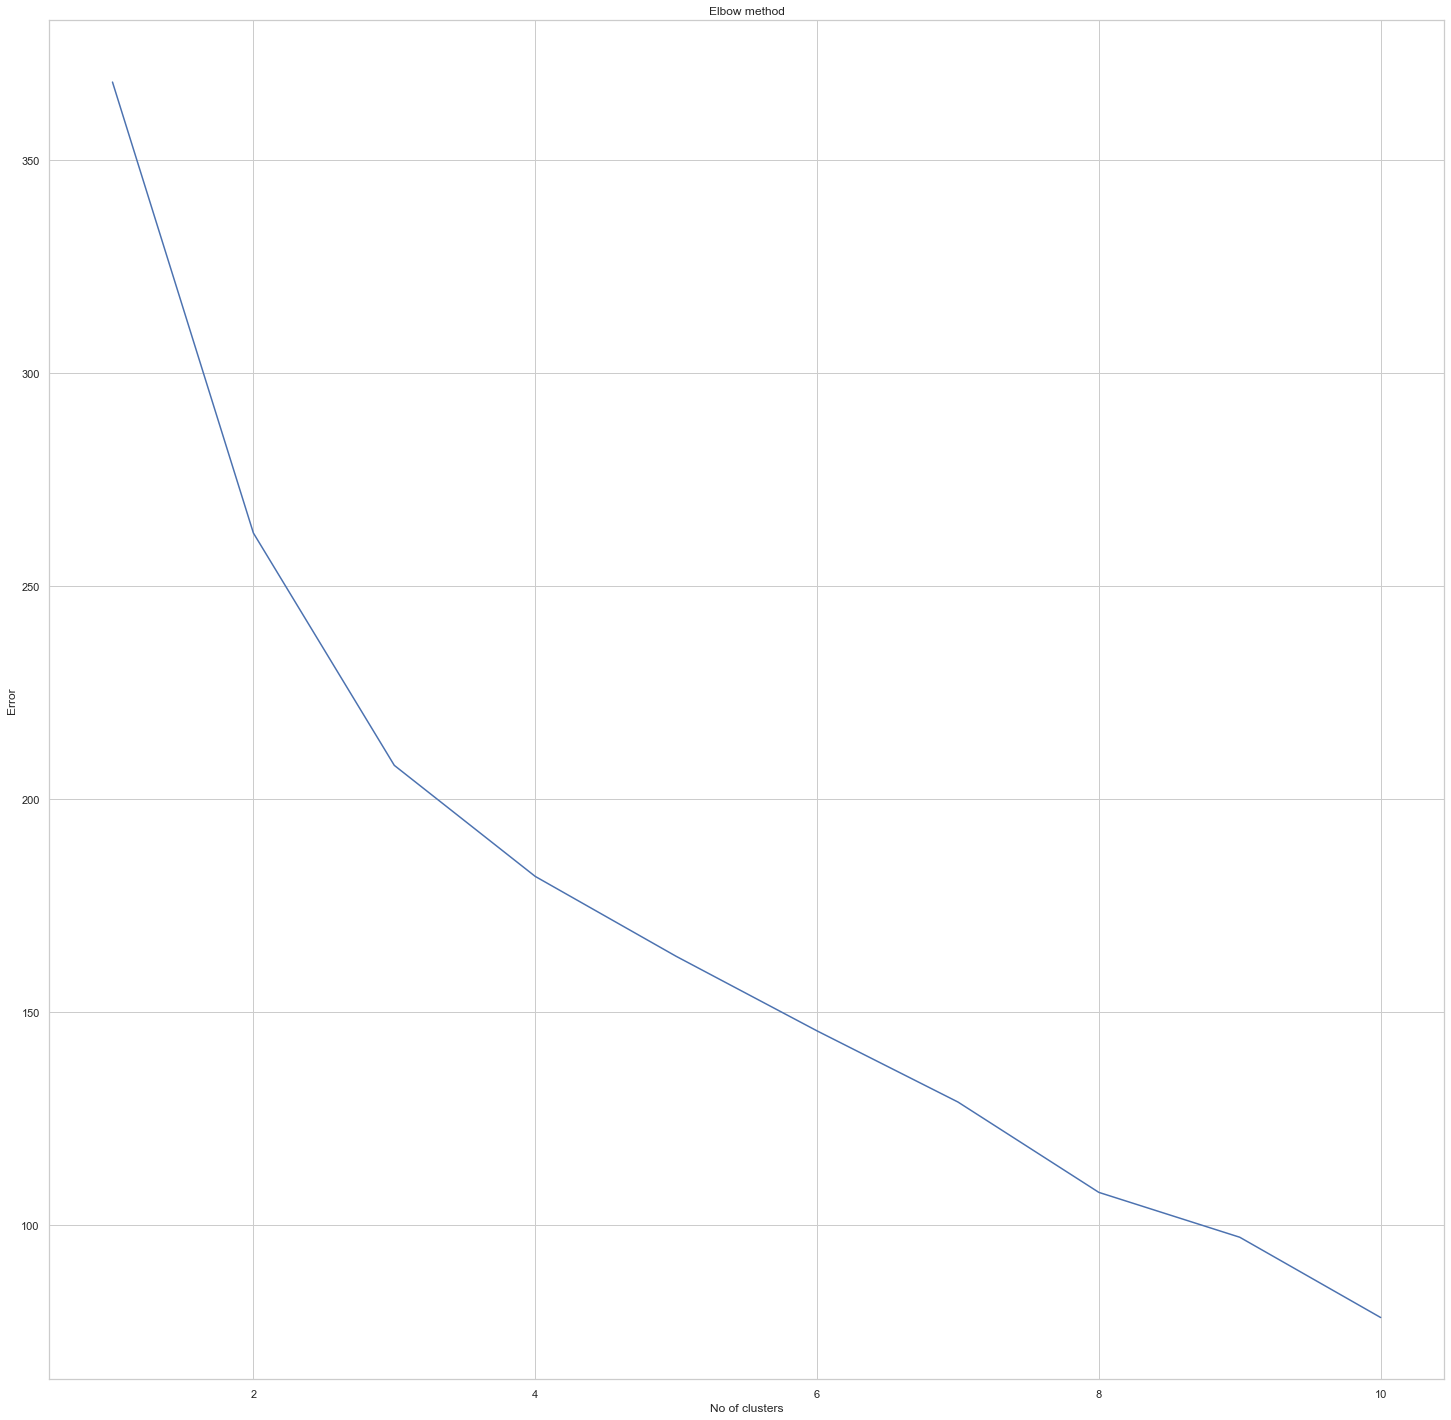

In [18]:
## Elbow method
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

WARNING: n_clusters=3 with 3 being the value derived from the "elbow method". This has to be changed in accordance to what the above graph represents.

In [19]:
kPro = KPrototypes(n_clusters=3, max_iter=600, n_init=50, init='Cao')

In [20]:
kResult = kPro.fit_predict(jitteredDf, categorical=[0])

In [21]:
jitteredDf['Clusters'] = kResult

In [22]:
jitteredMelt2 = pd.melt(jitteredDf, id_vars=['Quality', 'Clusters'], var_name='Instruments')

Displaying results of clustering

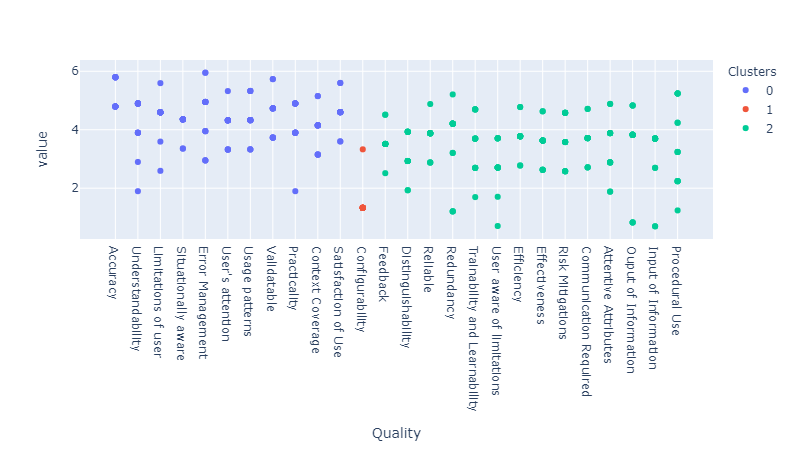

In [23]:
fig = px.scatter(jitteredMelt2, x="Quality", y="value", color="Clusters")
fig.show()

### Network Graphs / Directed and Un-Directed Graphs

The following functions are all related to the creation and display of Graphs.

In [24]:
def drawDetailedUndirectedGraphs(ds):
    for index in ds.index.values:
        tempGraph = nx.Graph()
        frames = ds.iloc[index]
        ## This occurs twice because the values were switched to text
        frames = frames[frames != 0]
        frames = frames[frames != '0']
        frames = frames.drop_duplicates(keep=False)
        tempGraph.add_nodes_from(frames.index.values)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        labels = nx.get_edge_attributes(tempGraph,'weight')
        nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
        nx.draw_circular(tempGraph, with_labels=True)
        plt.draw()
        plt.show()

In [25]:
def drawDetailedDirectedGraphs(ds):
    for index in ds.index.values:
        tempGraph = nx.DiGraph()
        frames = ds.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        tempGraph.add_nodes_from(frames.index.values)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        nx.draw_circular(tempGraph, with_labels=True)
        labels = nx.get_edge_attributes(tempGraph,'weight')
        nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
        plt.draw()
        plt.show()

In [26]:
def drawFullDetailedUndirectedGraphs(ds):
    tempGraph = nx.Graph()
    tempGraph.add_nodes_from(ds.columns)
    for index in ds.index.values:
        frames = ds.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [27]:
def drawFullDetailedDirectedGraphs(ds):
    tempGraph = nx.DiGraph()
    tempGraph.add_nodes_from(ds.columns)
    for index in ds.index.values:
        frames = ds.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

getFirst returns the first element of the first procedure so as to begin the graph.

In [28]:
def getFirst(frames):
    iterator = frames[frames == 1].index.values
    if len(iterator) == 0:
        return findIndexUsingNum(frames, 1)
    else:
        return iterator[0]

getSize returns the size of the procedure

In [29]:
def getSize(frame):
    size = frame.size
    for f in frame:
        if(type(f) == np.str):
            for c in f:
                if(c == ','):
                    size+=1
    return size

In [30]:
def findIndexUsingNum(frames, number):
    for frame in frames:
        if(type(frame) == np.str):
            nums = re.findall('\d+', frame)
            nums = list(map(int, nums))
            if number in nums:
                 return frames[frames == frame].index.values[0]
    return None

dropProdCol is a function built to check if the column "Procedures" is still in the dataframe and removes it if so.
The column serves no purpose for the creation of network graphs.

In [31]:
## Drop column from ds
def dropProdCol(dataframe):
    if 'Procedures' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Procedures'])
        return dataframe
    else:
        return dataframe

The following are all calls to display their respective graph construction function.
The construction functions construct one graph and a time, and so they are displayed using a loop.

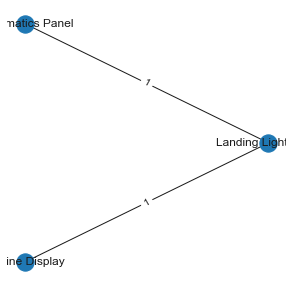

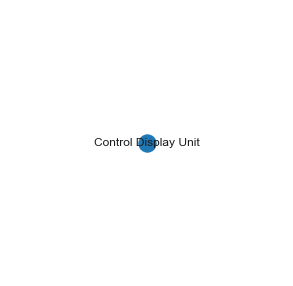

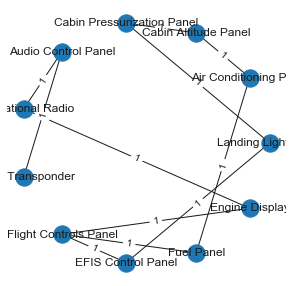

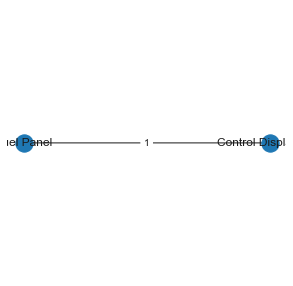

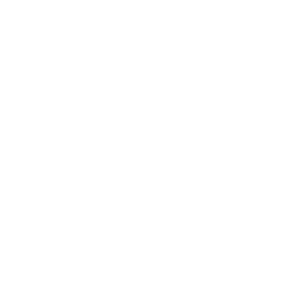

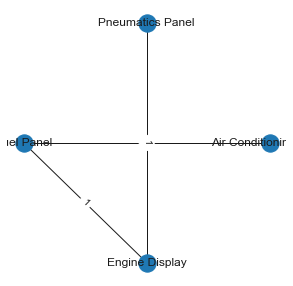

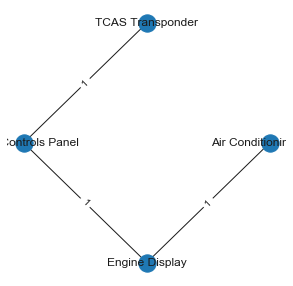

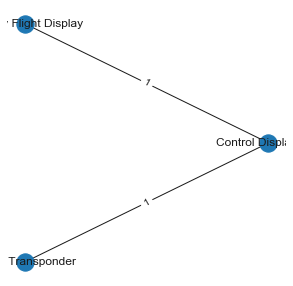

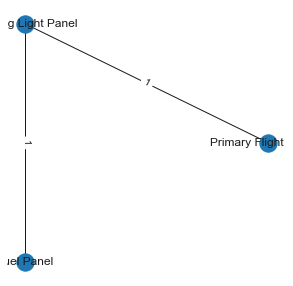

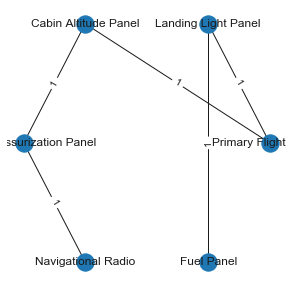

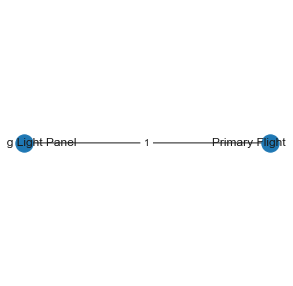

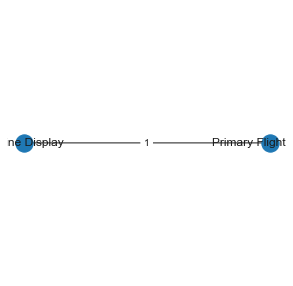

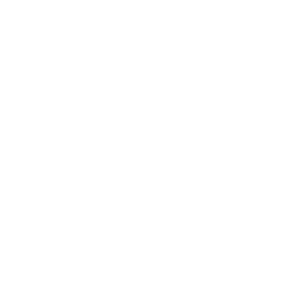

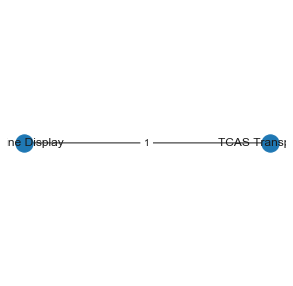

In [32]:
## Drawing them undirected but more detailed - one diagram for each phase
## This time the nodes which are connected are in sequence according to procedural use
ds = dropProdCol(ds)
drawDetailedUndirectedGraphs(ds)

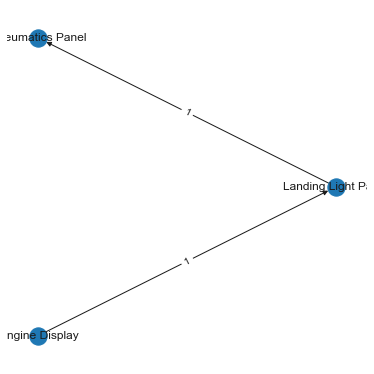

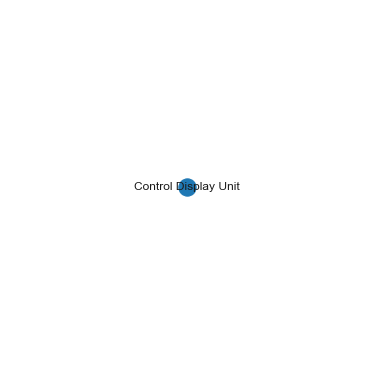

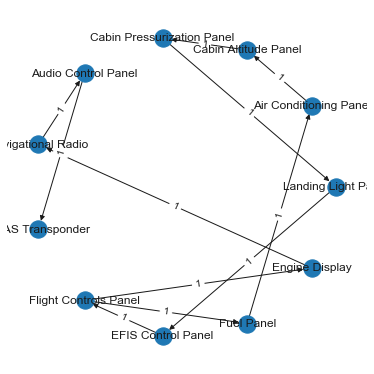

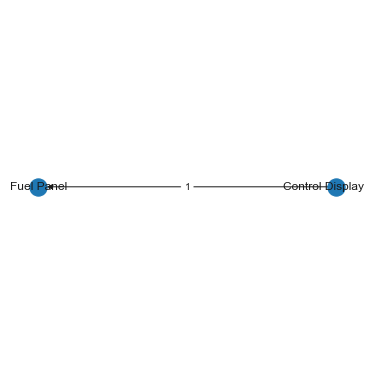

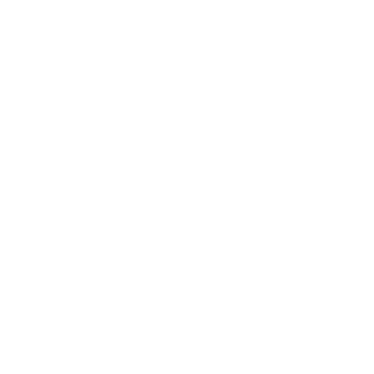

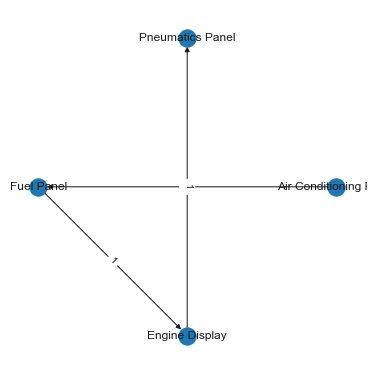

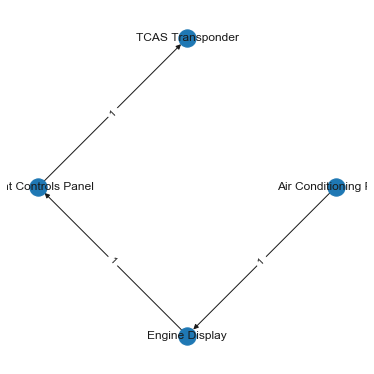

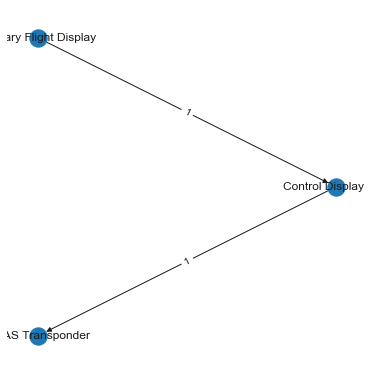

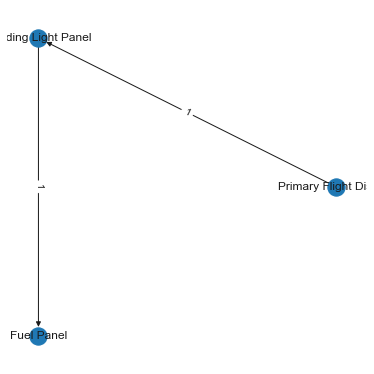

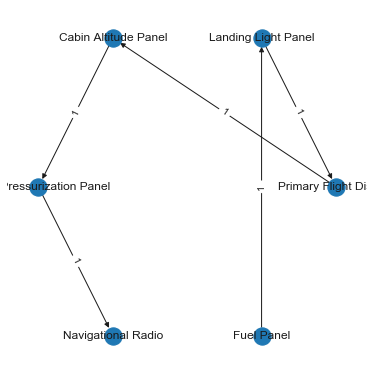

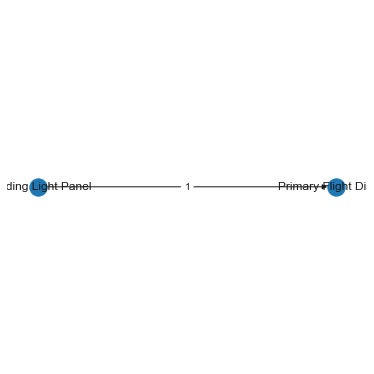

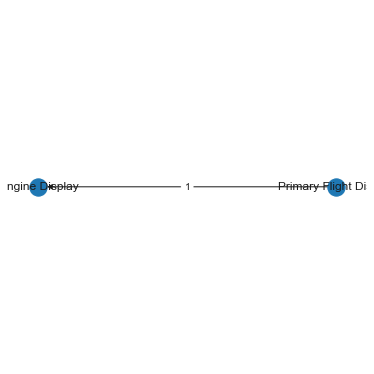

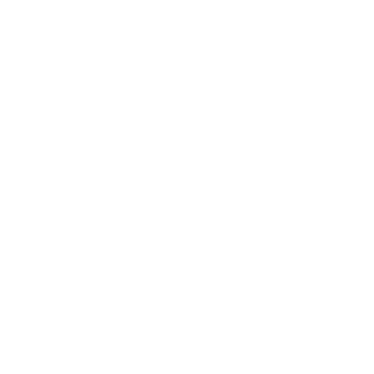

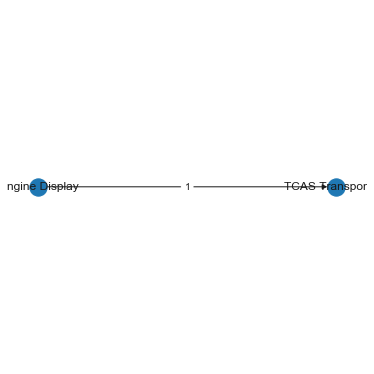

In [33]:
## Drawing them directed but more detailed - one diagram for each phase
## This time the nodes which are connected are in sequence according to procedural use
ds = dropProdCol(ds)
drawDetailedDirectedGraphs(ds)

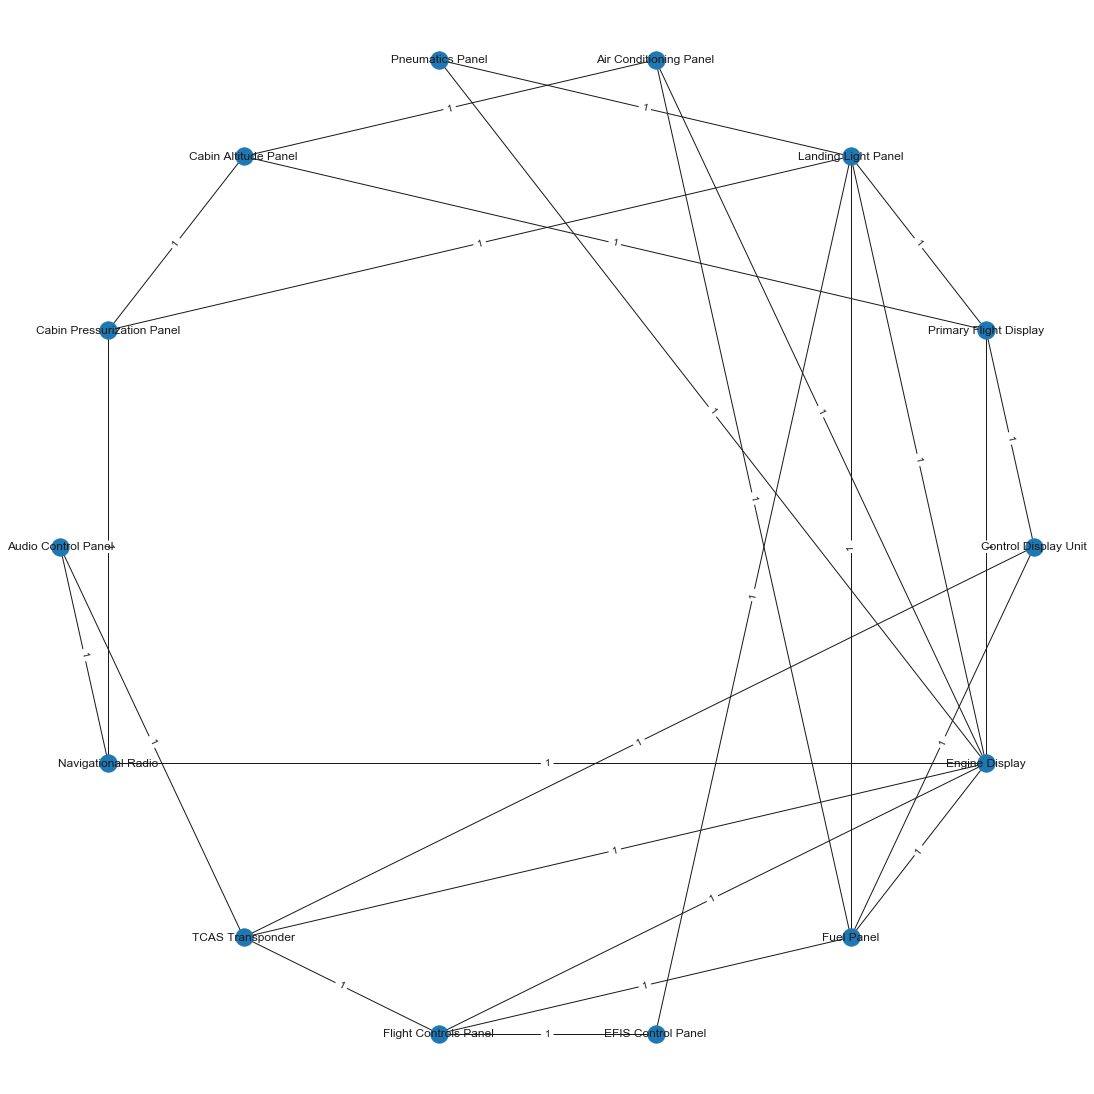

In [34]:
## Drawing full undirected graph - one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
drawFullDetailedUndirectedGraphs(ds)

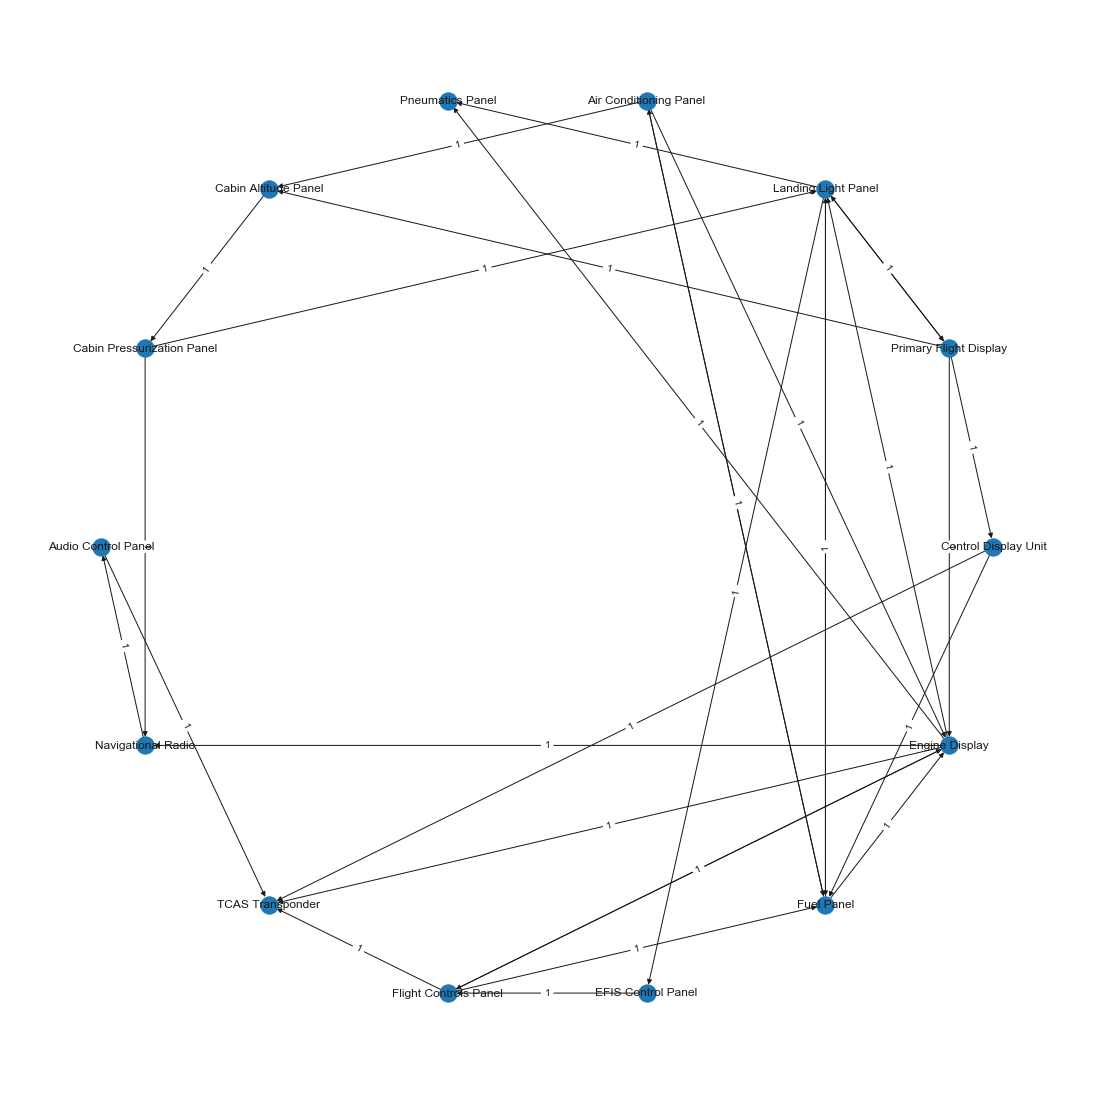

In [35]:
## Drawing full directed graph - one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
drawFullDetailedDirectedGraphs(ds)

In [36]:
def entireGraph_Undirected(dataFrame):
    counter = 1
    lastUsed = 0
    tempGraph = nx.Graph()
    tempGraph.add_nodes_from(dataFrame.columns)
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [37]:
def entireGraph_Directed(dataFrame):
    counter = 1
    lastUsed = 0
    tempGraph = nx.DiGraph()
    tempGraph.add_nodes_from(dataFrame.columns)
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

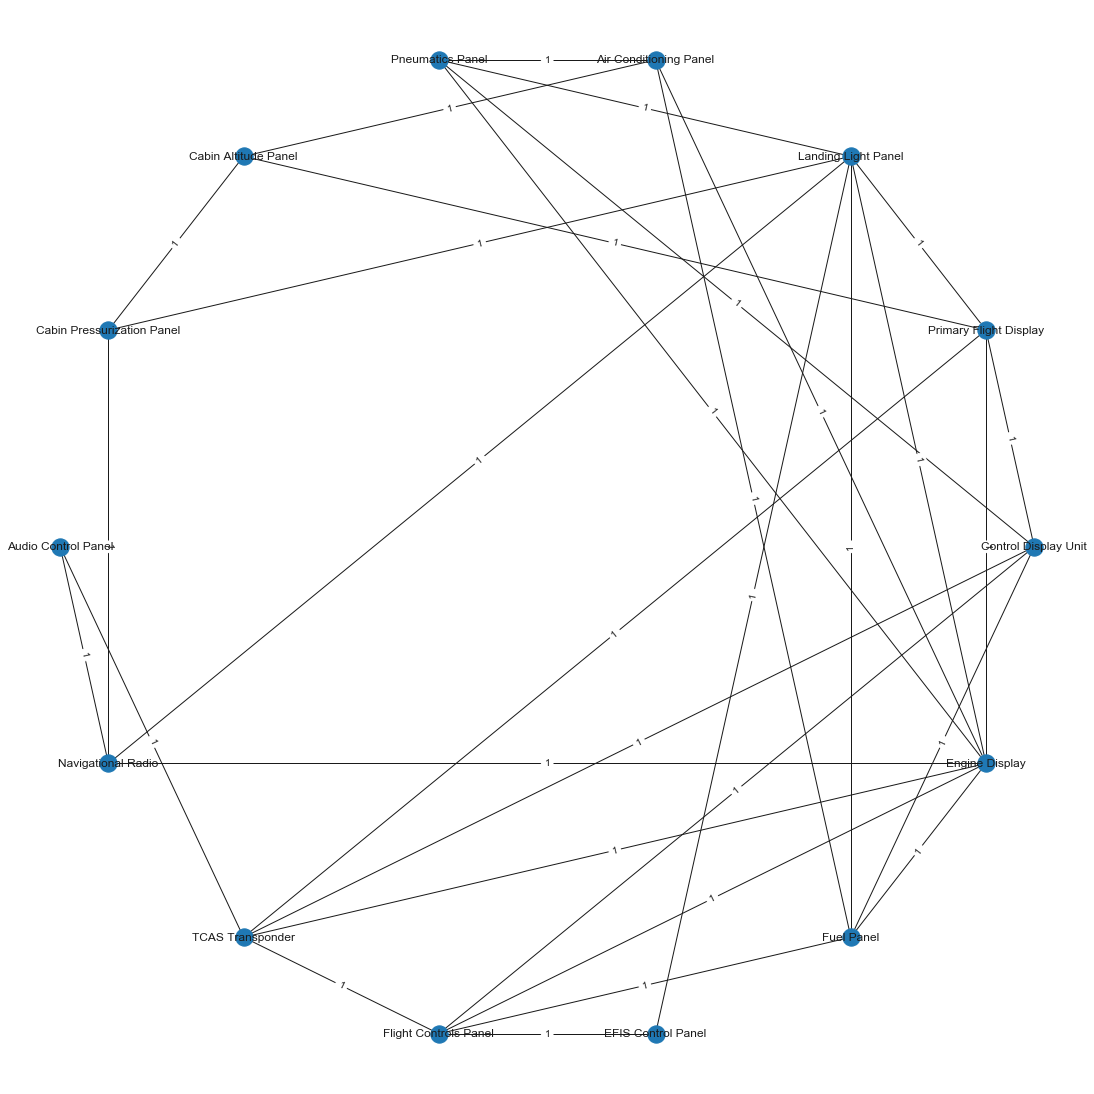

In [38]:
## Draw the entire graph with the procedures interconnected
## Undirected
ess = dropProdCol(ess)
entireGraph_Undirected(ess)

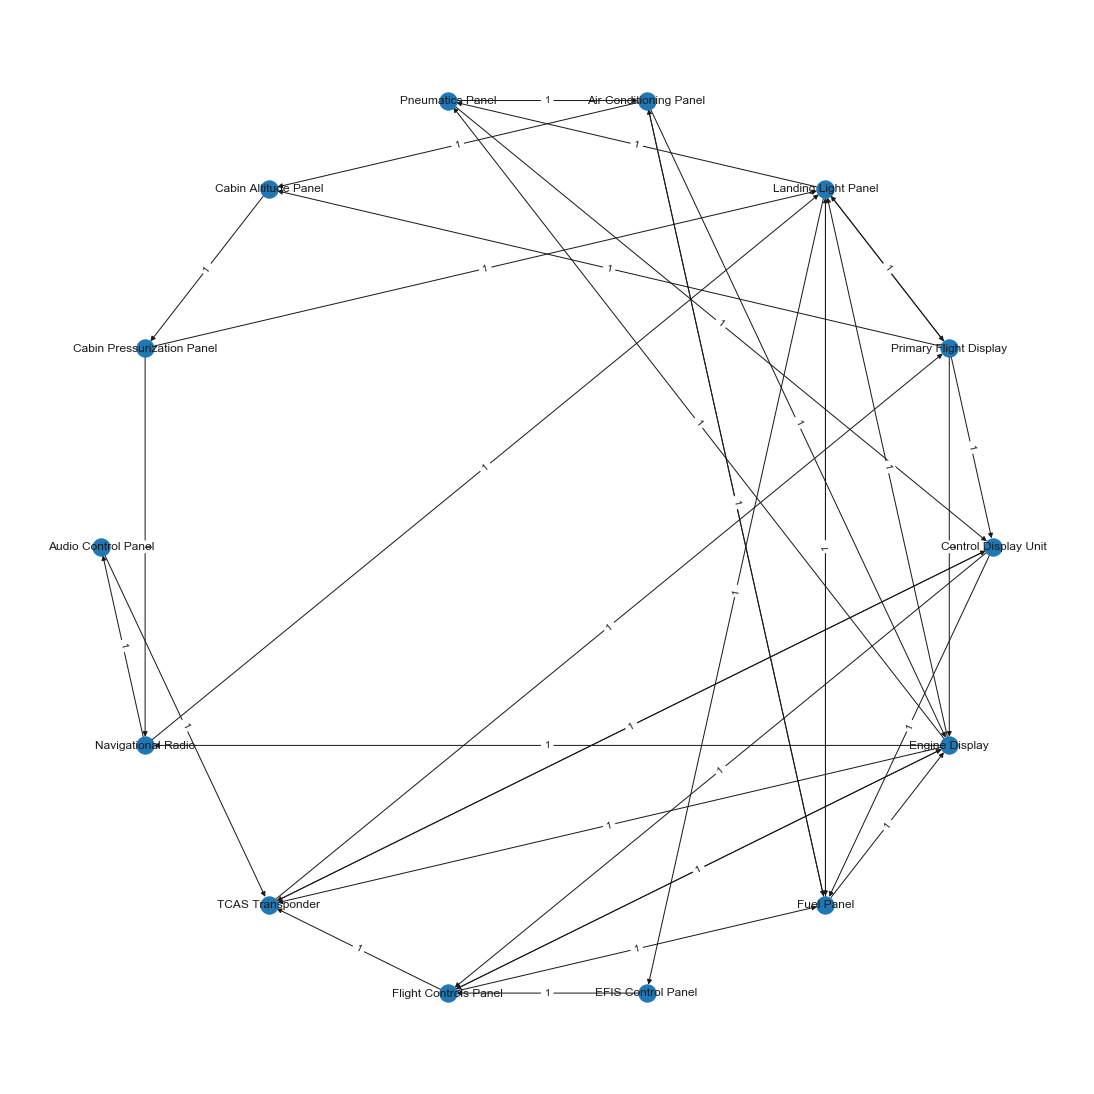

In [39]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
entireGraph_Directed(ess)

In [40]:
# Remove the "Quality" Column as it serves no purpose in data
# Remove the row "Procedural Use"
def graphTransformation(df):
    totals = []
    df = df[df.Quality != 'Procedural Use']
    for col in df.columns.values:
        if(col != 'Quality'):
            totals.append(sum(df[col]))
    transformationGraph = pd.DataFrame(columns=df.columns)
    transformationGraph = transformationGraph.drop(columns=['Quality'])
    ## New list of names
    newNameList = []
    for colName in transformationGraph.columns.values:
        newNameList.append(colName+'_2')
    transformationGraph.columns = newNameList
    tot = pd.Series(totals, index=transformationGraph.columns)
    transformationGraph = transformationGraph.append(tot, ignore_index=True)
    return transformationGraph

In [41]:
def entireGraph_Directed_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

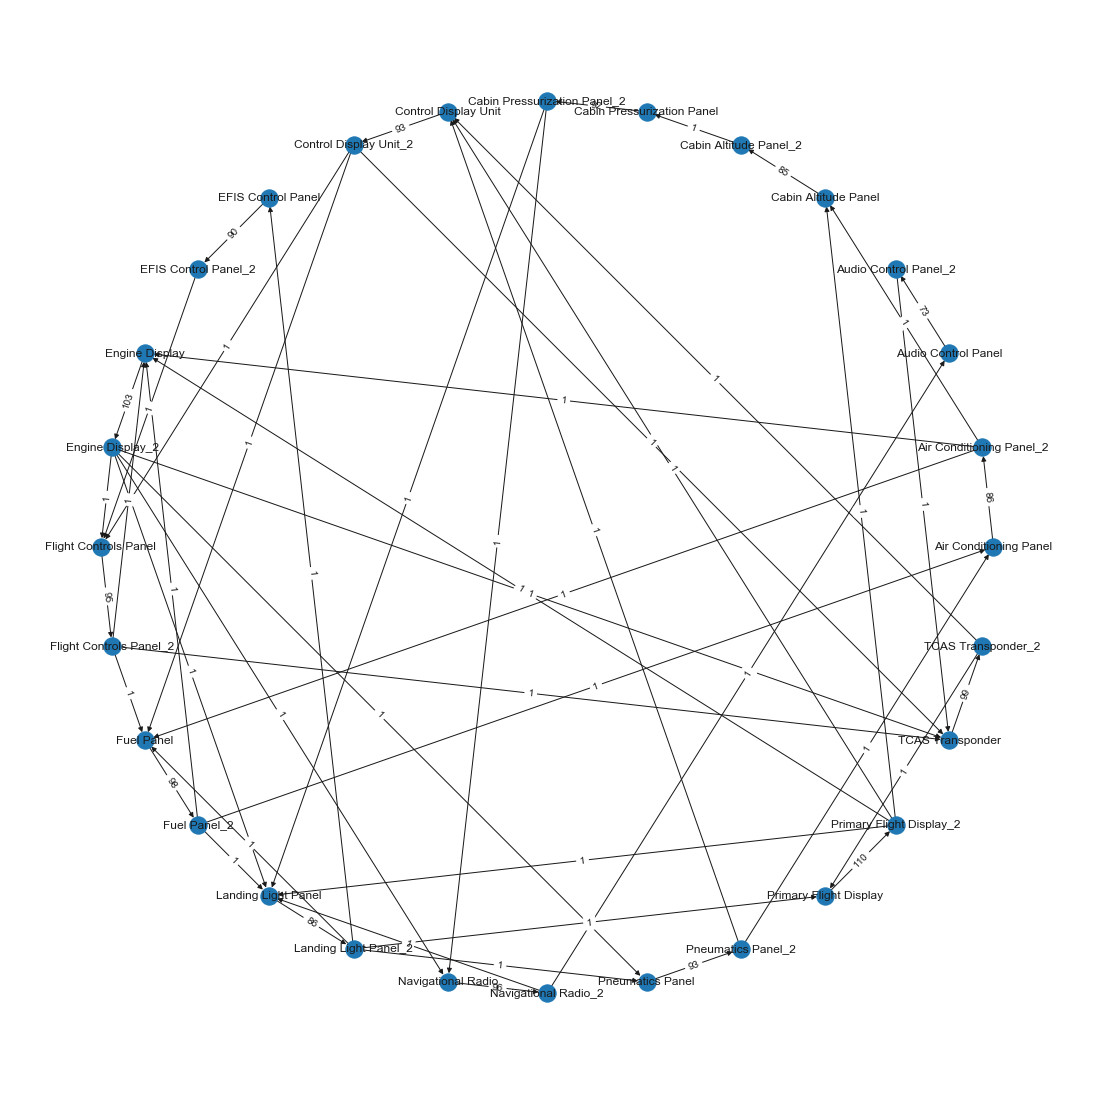

In [42]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
fullGraph_Directed_withWeights = entireGraph_Directed_withWeights(ess, df)

In [43]:
def drawFullDetailedDirectedGraphs_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']         
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

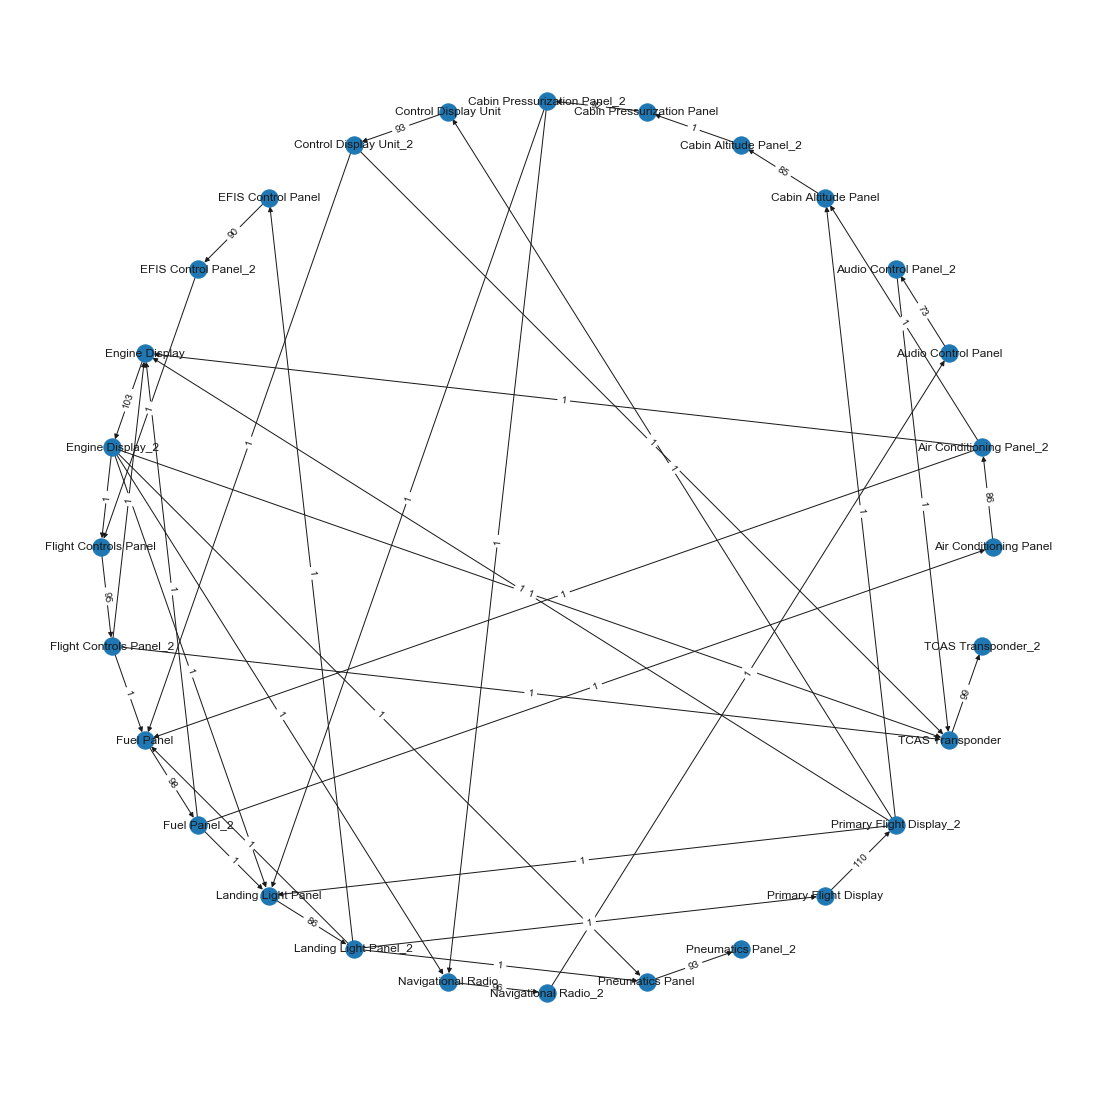

In [44]:
## Drawing full directed graph with weights- one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
procedureOnly_DirectedGraph_Full_Weighted = drawFullDetailedDirectedGraphs_withWeights(ds, df)